# Superstore Marketing Campaign - Machine Learning (Part2)

After having analyzed the variables of our dataset at length in detail, we will move on in this section to implementing a Machine Learning model to our data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msn
import warnings
warnings.filterwarnings('ignore')
import datetime
import numpy as np
%matplotlib inline 

data = pd.read_csv('/Users/nathan/Desktop/Étude Perso/DataSience/Machine Learning Project/superstore_data.csv', parse_dates = ['Dt_Customer'])
data2 = data.copy()
data.head()

,Id,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain
0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,...,111,189,218,1,4,4,6,1,1,0
1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,464,...,7,0,37,1,7,3,7,5,1,0
2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,134,...,15,2,30,1,3,2,5,2,0,0
3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,10,...,0,0,0,1,1,0,2,7,0,0
4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,6,...,11,0,34,2,3,1,2,7,1,0


In [2]:
currentDateTime = datetime.datetime.now()
date = currentDateTime.date()
year = date.strftime("%Y")

In [3]:
data['Customer_Age'] = int(year) - data.Year_Birth
data.drop('Year_Birth', axis = 1, inplace = True)

## Correlation 

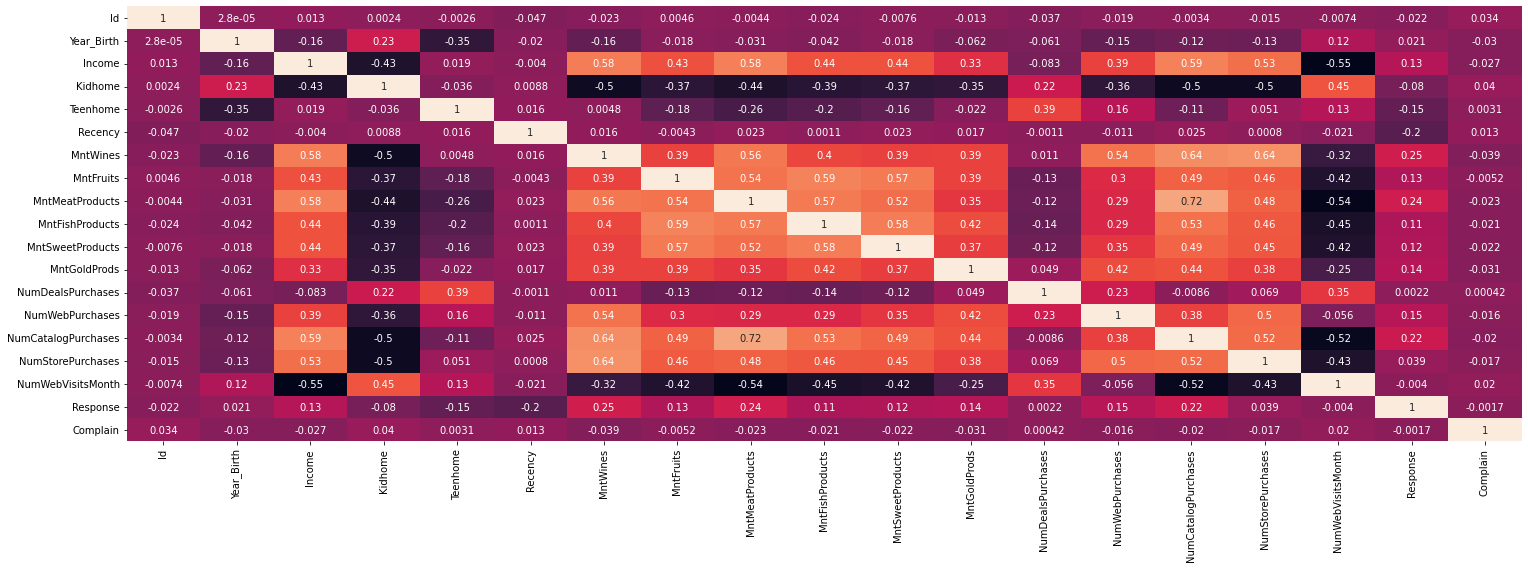

In [4]:
plt.figure(figsize=(25,8))
sns.heatmap(data2.corr(), cbar = False, annot = True);

## Remove or not the 'ID' column

A unique identifier can be used to identify a specific record, which can be useful if you need to refer to that record later or if you need to merge your data with other datasets.

In some cases, a unique identifier can introduce bias or nuisance effects into your machine learning model. For example, if you include a customer's unique identifier in your fraud prediction model, the model can learn to recognize fraudulent behaviors specific to that customer rather than generalizing fraud patterns to the whole population.

If the identifier is simply a random or arbitrary value, it may not add useful information to your machine learning model and may even introduce noise into your data.

In [5]:
# verification si le id est une valeur aléatoire

data[data.Id.duplicated()]

,Id,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_Age


In [6]:
data.Id.nunique() == data.shape[0]   # no relationship between the different IDs

True

In [7]:
# remove Id column 
data.drop('Id', axis = 1, inplace= True)

## Missing Values 

In [8]:
data.isna().sum()

Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
Response                0
Complain                0
Customer_Age            0
dtype: int64

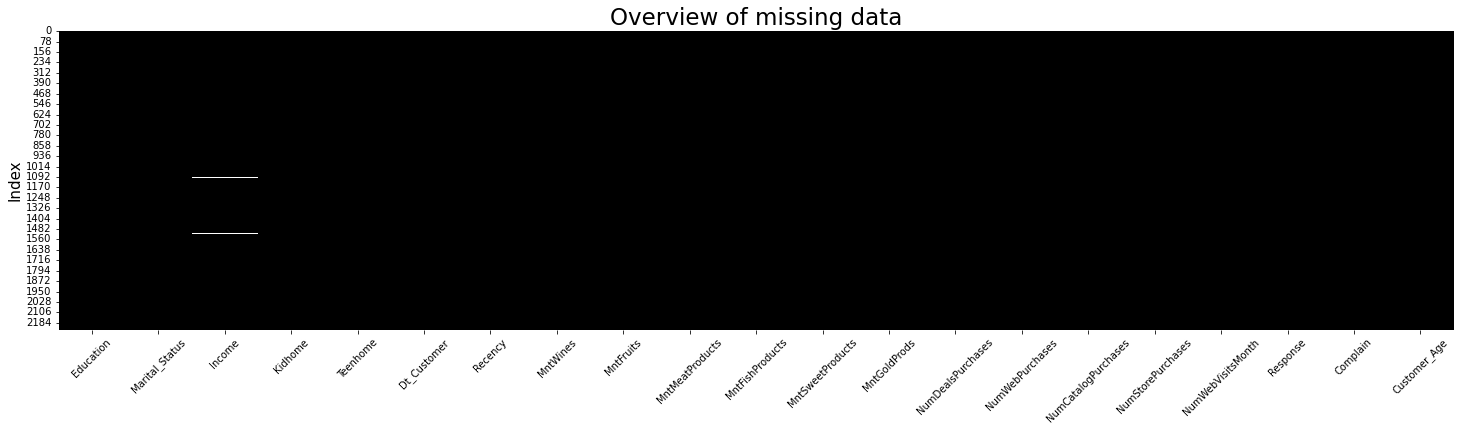

In [9]:
# apercu des données manquantes

plt.figure(figsize = (25,5.5))
sns.heatmap(data.isna(), cbar=False, cmap='CMRmap')
plt.title('Overview of missing data', size = 23, color = 'black')
plt.xticks(rotation = 45)
plt.ylabel('Index', color = 'black', size = 15);

### What metric to replace  missing values

In [10]:
# z-score function
def z_score(column, threshold) -> list :
    
    outlier = []
    count = 0
    index = []
    mean = column.mean()
    std = column.std()
    
    for i, element in enumerate(column):
        zscore = (element - mean) / std
        if np.abs(zscore) > threshold :
            outlier.append(element)
            index.append(i)
            count +=1
    return outlier

In [11]:
z_score(data['Income'], 3)

[157146.0,
 160803.0,
 666666.0,
 162397.0,
 157733.0,
 153924.0,
 156924.0,
 157243.0]

[157146.0, 160803.0, 666666.0, 162397.0, 157733.0, 153924.0, 156924.0, 157243.0]


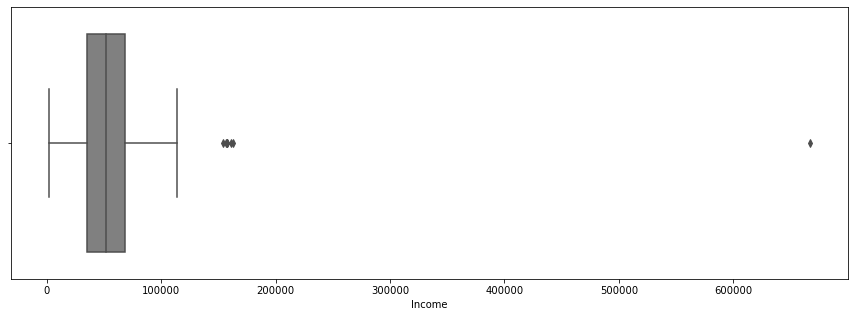

In [12]:
plt.figure(figsize = (15,5))
sns.boxplot(data.Income, color = 'grey');
print(z_score(data['Income'], 3))

Our sample is large enough in the face of a few outliers, the mean could be more representative of the central tendency of the data, even in the presence of these outliers.

### Imputation

In [13]:
from sklearn.impute import SimpleImputer

imputer_mean = SimpleImputer(strategy = 'mean')
data['Income'] = imputer_mean.fit_transform(data[['Income']])

In [14]:
data.Income.isna().sum()

0

## Target

In [15]:
data.Response.value_counts(normalize=True)

0    0.850893
1    0.149107
Name: Response, dtype: float64

**Observation Conclusion:** Our target column has 15% 1s and 85% 0s, this indicates that our data set is unbalanced. This can cause problems when training classification models, as the models can tend to predict the majority class (0) with high accuracy and poor accuracy for the minority class (1).

There are several techniques you can use to deal with this problem:

  * Downsampling: You can select a random subset of the examples from the majority class (0) to balance the number of examples from both classes. However, this can reduce the size of your dataset and lead to loss of information.

  * Oversampling: You can use oversampling techniques, such as random duplication or synthetic generation of new observations of the minority class (1) to increase the number of examples of this class. However, it can also lead to overfitting if the data is too similar.

* Use of imbalanced machine learning techniques: Many machine learning algorithms have parameters that allow accounting for class imbalances, such as class weights, asymmetric error costs, or evaluation metrics specific to unbalanced classes.

* Use of ensemble techniques: Ensemble techniques, such as bagging, boosting, or stacking, can improve model performance on unbalanced datasets by combining predictions from multiple base models.

## Encoding

In [16]:
data.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Customer_Age
0,Graduation,Divorced,84835.0,0,0,2014-06-16,0,189,104,379,...,189,218,1,4,4,6,1,1,0,53
1,Graduation,Single,57091.0,0,0,2014-06-15,0,464,5,64,...,0,37,1,7,3,7,5,1,0,62
2,Graduation,Married,67267.0,0,1,2014-05-13,0,134,11,59,...,2,30,1,3,2,5,2,0,0,65
3,Graduation,Together,32474.0,1,1,2014-11-05,0,10,0,1,...,0,0,1,1,0,2,7,0,0,56
4,Graduation,Single,21474.0,1,0,2014-08-04,0,6,16,24,...,0,34,2,3,1,2,7,1,0,34


In [17]:
data.dtypes.value_counts()

int64             17
object             2
float64            1
datetime64[ns]     1
dtype: int64

### Label Encoding vs One_Hot_Encoding

The **LabelEncoder** is a technique for transforming categorical data into integers, where each category is assigned a unique number. This technique is useful when you have ordinal categories, that is, categories that have a certain hierarchical structure or order. For example, the "low", "medium" and "high" categories have a natural order that can be captured by the LabelEncoder.

The **OneHotEncoder** is another technique for transforming categorical data into a digital representation, where each category is represented by a binary vector. This technique is useful when you have nominal categories, that is, categories that have no natural or hierarchical order. For example, the categories "red", "blue" and "green" have no natural order and can be represented by a binary vector (1 for the corresponding category and 0 for the other categories).

In general, the OneHotEncoder is often preferred over the LabelEncoder for nominal categorical data because it avoids skewing machine learning models into believing that there is a hierarchical or ordering structure between categories. However, if you have ordinal categories, the LabelEncoder might be a reasonable option to consider.

### 0bject columns 

In [18]:
data.Education.unique()  # label encoding (il existe un ordre)

array(['Graduation', 'PhD', '2n Cycle', 'Master', 'Basic'], dtype=object)

In [19]:
data.Marital_Status.unique()  # one_hot_encoding (pas d'ordre hiérarchique)

array(['Divorced', 'Single', 'Married', 'Together', 'Widow', 'YOLO',
       'Alone', 'Absurd'], dtype=object)

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label = LabelEncoder()
one_hot = OneHotEncoder()

data['Education'] = label.fit_transform(data['Education'])

In [21]:
marital_status = one_hot.fit_transform(data[['Marital_Status']])
marital_status = marital_status.toarray()                         # Convertir la matrice sparse en un tableau numpy

# Ajouter les colonnes encodées au DataFrame
data = pd.concat([data, pd.DataFrame(marital_status, columns = one_hot.get_feature_names(['Marital_Status']))], axis=1)
data.drop('Marital_Status', axis = 1, inplace = True)

In [22]:
data.head()

,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Customer_Age,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,2,84835.0,0,0,2014-06-16,0,189,104,379,111,...,0,53,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,57091.0,0,0,2014-06-15,0,464,5,64,7,...,0,62,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,67267.0,0,1,2014-05-13,0,134,11,59,15,...,0,65,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,32474.0,1,1,2014-11-05,0,10,0,1,0,...,0,56,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2,21474.0,1,0,2014-08-04,0,6,16,24,11,...,0,34,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
data.dtypes.value_counts()

int64             18
float64            9
datetime64[ns]     1
dtype: int64

### Datetime column

In [24]:
data['Subscription_Day'] = data.Dt_Customer.dt.day
data['Subscription_Month'] = data.Dt_Customer.dt.month
data['Subscription_Year'] = data.Dt_Customer.dt.year

data.drop('Dt_Customer', axis = 1, inplace = True)

In [25]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Subscription_Day,Subscription_Month,Subscription_Year
0,2,84835.0,0,0,0,189,104,379,111,189,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16,6,2014
1,2,57091.0,0,0,0,464,5,64,7,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15,6,2014
2,2,67267.0,0,1,0,134,11,59,15,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13,5,2014
3,2,32474.0,1,1,0,10,0,1,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,11,2014
4,2,21474.0,1,0,0,6,16,24,11,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,8,2014


In [26]:
data.dtypes.value_counts()

int64      21
float64     9
dtype: int64

# Feature Selection

### Variance 

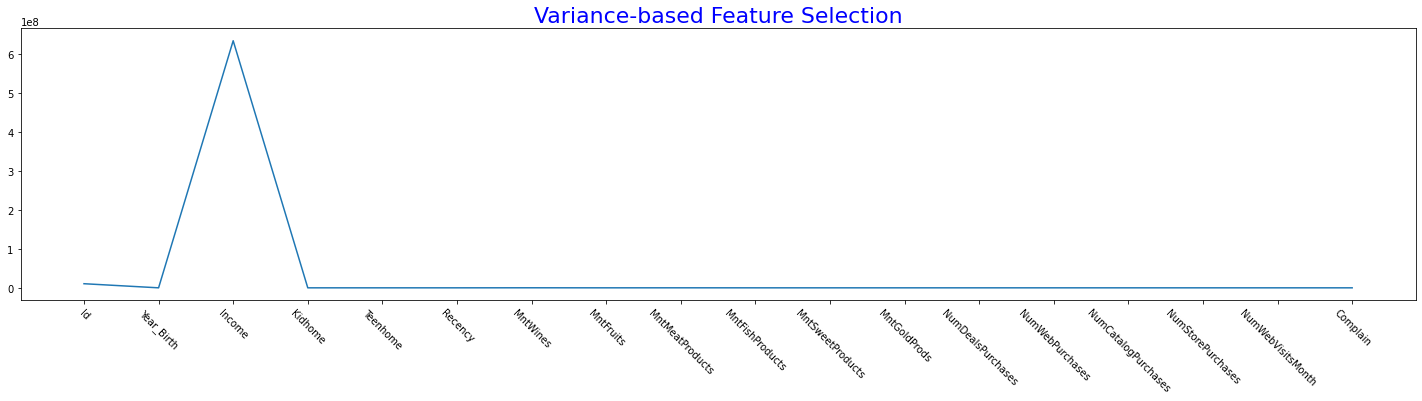

In [27]:
x_feature = data2.drop('Response', axis = 1)
y_feature = data2.Response

var = np.var(x_feature, axis=0)

plt.figure(figsize=(25,5))
plt.plot(var)
plt.title('Variance-based Feature Selection', size = 22, color = 'blue')
plt.xticks(rotation = -45);

## SelectKBest 

This model selects the n variable X whose test of dependence with Y is the highest (inverse model to VarianceThreshold ).

It is important to include a dependency test in the model:
   * Classification:
        * chi2(X,Y)
        * f_classif(X,Y) (ANOVA)

### Anova(f_classif)

In [28]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

data_copy = data.copy()
x_data_copy = data_copy.drop('Response', axis = 1)
y_data_copy = data_copy.Response

selector = SelectKBest(f_classif, k = 15)    # k = le nombre de meilleurs variables dependantes de la target
selector.fit_transform(x_data_copy, y_data_copy)
lst_feature_selection = selector.get_support()

print(f'The 15 selected features are:\n{x_data_copy.columns[lst_feature_selection]}')

The 15 selected features are:
Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumWebPurchases', 'NumCatalogPurchases',
       'Marital_Status_Single', 'Subscription_Year'],
      dtype='object')


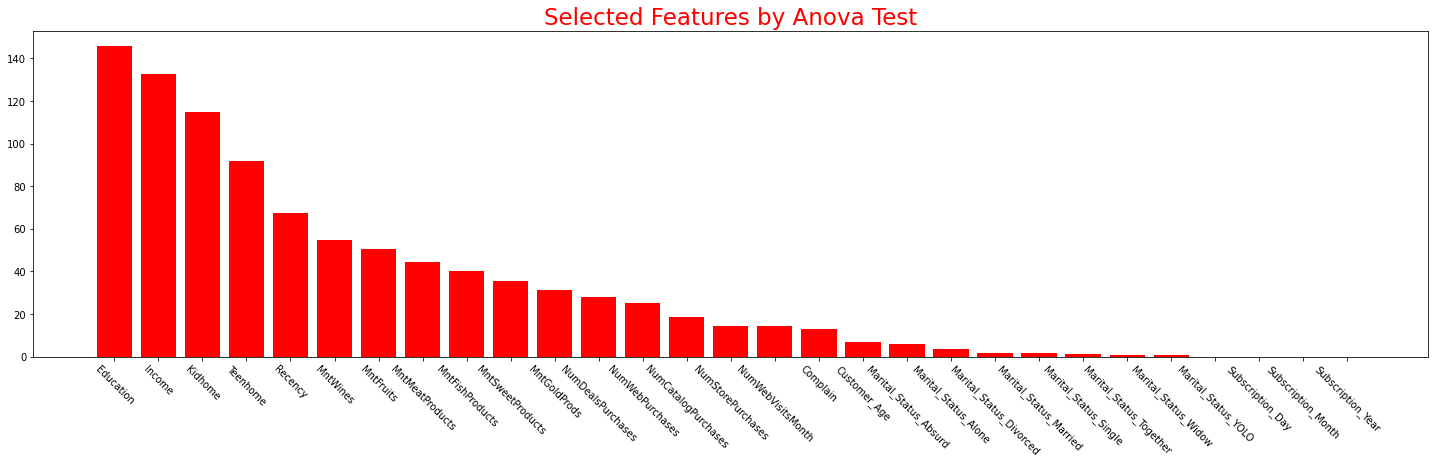

In [29]:
score = selector.scores_
sorted_indice = np.argsort(score)[::-1]

plt.figure(figsize=(25,6))
plt.xticks(rotation = -45)
plt.title('Selected Features by Anova Test', size = 23, color = 'red')
plt.bar(x_data_copy.columns, height=score[sorted_indice], color = 'red');

**Note:** We have in front of us the best variables to keep for our model (which vary the most depending on our target). We keep these data aside for the moment and we will use them later for the optimization of our model.

### KBinDiscretizer  (With chi2 test)


In [30]:
from sklearn.preprocessing import KBinsDiscretizer

disc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_discrete = disc.fit_transform(x_data_copy)


selector_chi2 = SelectKBest(chi2, k = 15)   
selector_chi2.fit_transform(X_discrete, y_data_copy);

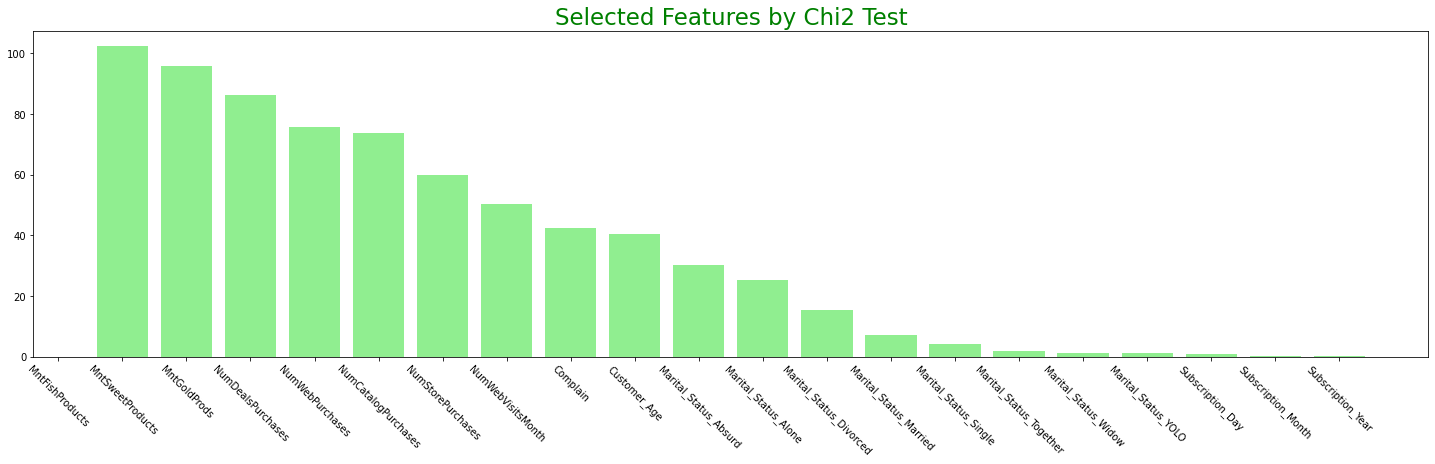

In [31]:
chi2_score = selector_chi2.scores_
sorted_indice_chi2 = np.argsort(chi2_score)[::-1]

plt.figure(figsize=(25,6))
plt.xticks(rotation = -45)
plt.title('Selected Features by Chi2 Test', size = 23, color = 'green')
plt.bar(x_data_copy.columns, height = chi2_score[sorted_indice_chi2], color = 'lightgreen');

## Normalisation & Strandardisation

**When to favor standardization and when to standardization?**

* If you have data that is evenly or nearly evenly distributed, normalization may be more appropriate than standardization. Normalization reduces the range of values for each feature by dividing them by their range, which can be useful for features with a large range, while preserving the original distribution of each feature.

* If you have data that has a Gaussian distribution, standardization may be more appropriate than normalization. Standardization transforms features using their mean and standard deviation, which can be useful for algorithms that assume a Gaussian distribution of features.

* If you are using a model that is sensitive to feature scale, normalization or standardization may both be appropriate. In this case, you should experiment with both techniques to determine which gives the best results.

* If you are using a clustering or classification method that is based on the distance between points, standardization may be more appropriate as it helps put all features on the same scale and can help make the distances between points more significant.

In [32]:
# split data
x = data.drop('Response', axis = 1)
Y = data.Response

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standard_numpy = scaler.fit_transform(x)

In [34]:
standard_data = pd.DataFrame(data = standard_numpy, columns = x.columns)

In [35]:
standard_data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Subscription_Day,Subscription_Month,Subscription_Year
0,-0.350141,1.301833,-0.825218,-0.929894,-1.696001,-0.341540,1.953945,0.939667,1.345274,3.923722,...,-0.036621,2.941967,-0.792406,-0.522233,-0.591099,-0.188676,-0.029894,0.046903,-0.148093,1.420036
1,-0.350141,0.193501,-0.825218,-0.929894,-1.696001,0.475643,-0.535709,-0.456207,-0.558902,-0.655733,...,-0.036621,-0.339909,-0.792406,1.914854,-0.591099,-0.188676,-0.029894,-0.066310,-0.148093,1.420036
2,-0.350141,0.600017,-0.825218,0.906934,-1.696001,-0.504976,-0.384821,-0.478364,-0.412427,-0.607273,...,-0.036621,-0.339909,1.261980,-0.522233,-0.591099,-0.188676,-0.029894,-0.292736,-0.432838,1.420036
3,-0.350141,-0.789912,1.032559,0.906934,-1.696001,-0.873451,-0.661449,-0.735382,-0.687068,-0.655733,...,-0.036621,-0.339909,-0.792406,-0.522233,1.691765,-0.188676,-0.029894,-1.198440,1.275633,1.420036
4,-0.350141,-1.229346,1.032559,-0.929894,-1.696001,-0.885337,-0.259081,-0.633461,-0.485665,-0.655733,...,-0.036621,-0.339909,-0.792406,1.914854,-0.591099,-0.188676,-0.029894,-1.311653,0.421397,1.420036


## Modelisation

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

np.random.seed(0)
X = standard_data
lst_model = [LogisticRegression(), DecisionTreeClassifier(),  KNeighborsClassifier(), GaussianNB(), svm.SVC(), RandomForestClassifier()]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### About metrics

   * Accuracy - The accuracy of the model in decimal form. Perfect accuracy is equal to 1.0.
   * Precision - Indicates the proportion of positive identifications (model predicted class 1) which were actually correct. A model which produces no false positives has a precision of 1.0.
   * Recall - Indicates the proportion of actual positives which were correctly classified. A model which produces no false negatives has a recall of 1.0.
   * F1 score - A combination of precision and recall. A perfect model achieves an F1 score of 1.0.

### Important 

Our dataset has an unbalanced target, i.e. the classes we are trying to predict are not equally represented, it is important to choose metrics that take this aspect into account.
Here are some classification metrics you can use in this case:

 * Confusion matrix: It allows you to visualize the performance of the model by comparing predictions with true values. The confusion matrix can be used to calculate other metrics such as precision, recall, F1-score, etc.

* Precision: It measures the number of correct predictions relative to the total number of predictions. It is usually used when the minority class is the one being identified.

* Recall: It measures the number of correct predictions for the minority class relative to the total number of true observations for that class. This metric is also called "sensitivity" or "true positive rate."

* F1-score: It is a harmonic mean of precision and recall and is often used as an overall measure of a classification model's performance.

* Receiver Operating Characteristic Area Under the Curve (ROC AUC): It measures the model's ability to discriminate between positive and negative classes by considering all possible thresholds. It is often used when the classes are highly imbalanced.

It is important to choose metrics based on the objective of your model and the nature of your data. In general, it is recommended to use multiple metrics to get an overview of the model's performance.

In [37]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score

np.random.seed(0)

dict_f1score = {}
dict_precision = {}
dict_recall = {}

def metrics(model_metric = False, conf_matrix = False, classif = False):

    for i, element in enumerate(lst_model):
        model = element
        model_names = ['LogisticRegression', 'DecisionTreeClassifier',  'KNeighborsClassifier', 'GaussianNB', 'svm.SVC', 'RandomForestClassifier']
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        if model_metric : 

            print(f'For the model : {model} :')
            print(f'The recall_score is : {recall_score(y_test, y_pred)}')  
            print(f'The f1_score is : {f1_score(y_test, y_pred)}') 
            print(f'The precision_score is : {precision_score(y_test, y_pred)}')  
            print(f'The accuracy_score is : {accuracy_score(y_test, y_pred)}\n')  
        
        elif confusion_matrix : 
            plt.figure(figsize=(6,4))
            plt.title(model)
            sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cbar = False, fmt = 'g', cmap="YlGnBu");
            
        elif classif :
            print(classification_report(y_test, y_pred))
            print()

        dict_f1score[model_names[i]] = f1_score(y_test, y_pred)
        dict_precision[model_names[i]] = precision_score(y_test, y_pred)
        dict_recall[model_names[i]] = recall_score(y_test, y_pred)

In [38]:
metrics(model_metric = True)

For the model : LogisticRegression() :
The recall_score is : 0.359375
The f1_score is : 0.4554455445544554
The precision_score is : 0.6216216216216216
The accuracy_score is : 0.8772321428571429

For the model : DecisionTreeClassifier() :
The recall_score is : 0.484375
The f1_score is : 0.4558823529411765
The precision_score is : 0.4305555555555556
The accuracy_score is : 0.8348214285714286

For the model : KNeighborsClassifier() :
The recall_score is : 0.203125
The f1_score is : 0.2826086956521739
The precision_score is : 0.4642857142857143
The accuracy_score is : 0.8526785714285714

For the model : GaussianNB() :
The recall_score is : 0.515625
The f1_score is : 0.4782608695652174
The precision_score is : 0.44594594594594594
The accuracy_score is : 0.8392857142857143

For the model : SVC() :
The recall_score is : 0.234375
The f1_score is : 0.35294117647058826
The precision_score is : 0.7142857142857143
The accuracy_score is : 0.8772321428571429

For the model : RandomForestClassifier()

In [39]:
# Sort the dictionary by values in descending order

sorted_f1 = dict(sorted(dict_f1score.items(), key = lambda item: item[1], reverse = True))
sorted_precision = dict(sorted(dict_precision.items(), key = lambda item: item[1], reverse = True))
sorted_recall = dict(sorted(dict_recall.items(), key = lambda item: item[1], reverse = True))

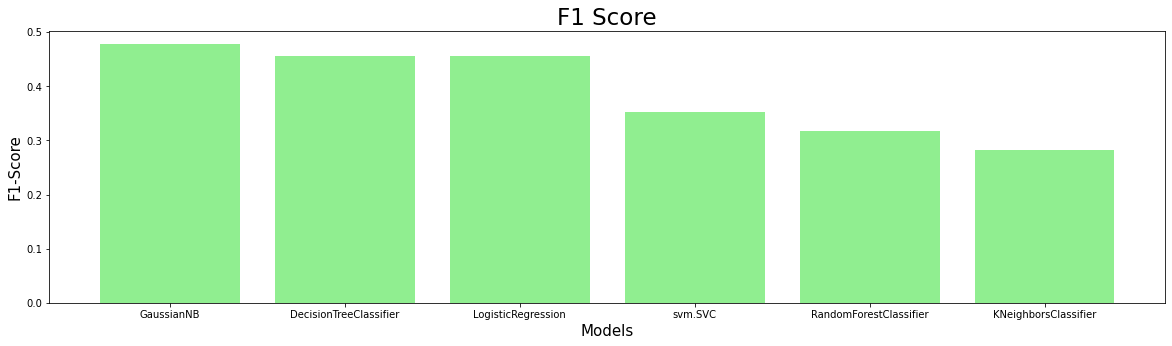

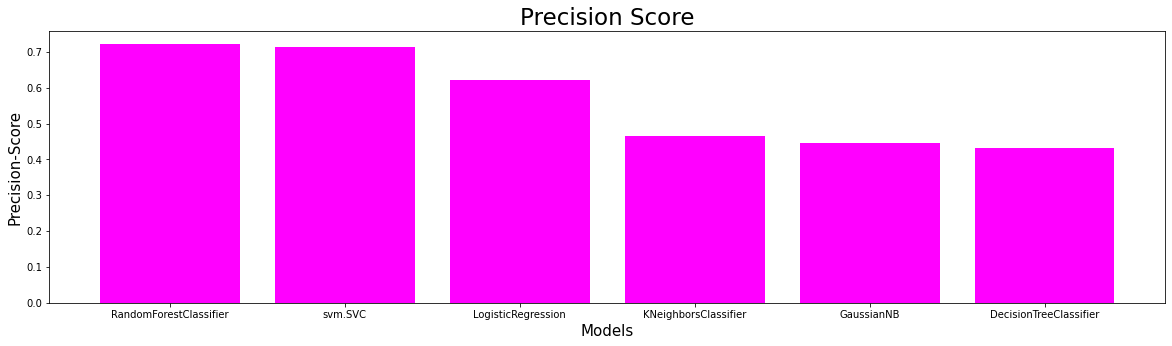

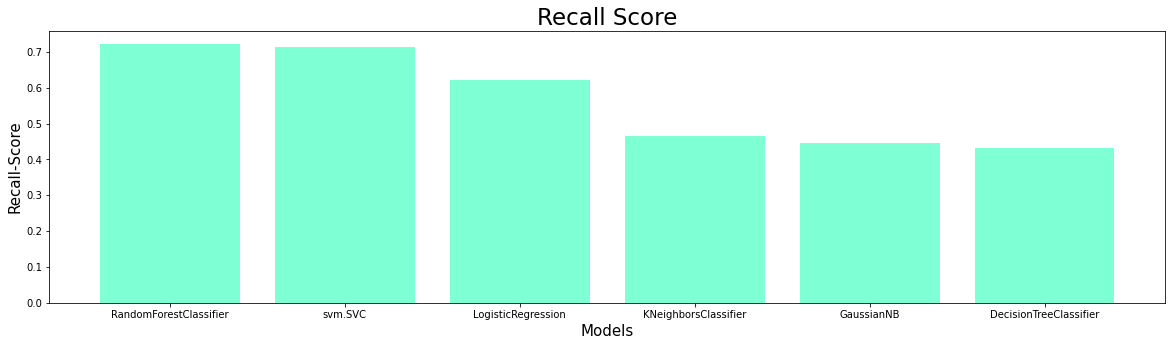

In [40]:
my_f1 = sorted_f1.items()
a, b = zip(*my_f1)

my_precision = sorted_precision.items()
c , d = zip(*my_precision)

my_recall = sorted_recall.items()
e , f = zip(*my_precision)

plt.figure(figsize = (20,5))
plt.bar(a, b, color = 'lightgreen')
plt.title('F1 Score', size = 23, color = 'black')
plt.xlabel('Models', size = 15, color = 'black')
plt.ylabel('F1-Score', size = 15, color = 'black');


plt.figure(figsize = (20,5))
plt.bar(c, d, color = 'magenta')
plt.title('Precision Score', size = 23, color = 'black')
plt.xlabel('Models', size = 15, color = 'black')
plt.ylabel('Precision-Score', size = 15, color = 'black');


plt.figure(figsize = (20,5))
plt.bar(e, f, color = 'aquamarine')
plt.title('Recall Score', size = 23, color = 'black')
plt.xlabel('Models', size = 15, color = 'black')
plt.ylabel('Recall-Score', size = 15, color = 'black');

## Which Model..

To know according to which metric we will choose our model, it is important to evaluate the impact of misclassifications.

If misclassifications in the minority class have a large impact on your use case, it can be better to choose a model that has a higher F1 score, even if it has a lower precision and/or recall score.

On the other hand, if misclassifications in the minority class have less impact, you can choose to use the model with the highest precision and recall scores.

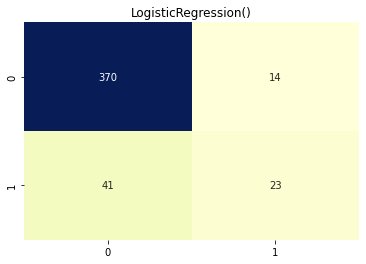

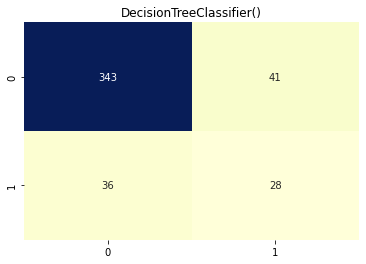

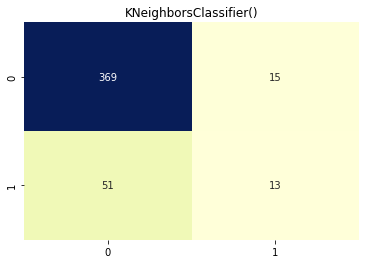

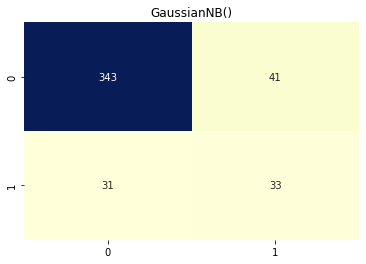

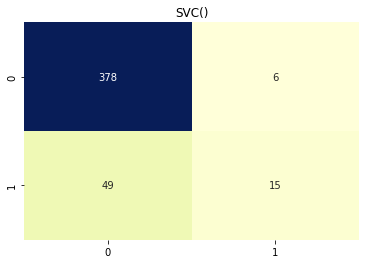

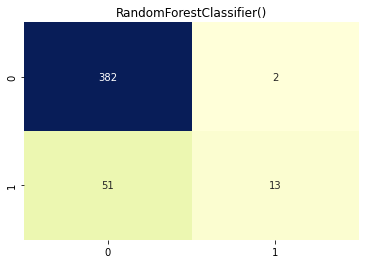

In [41]:
metrics(conf_matrix=True)

**Conclusion:** We can see from this report that most models predict with near perfection the majority class (0): 98.6% good predictions for the Randon Forest. However, we have a big problem with the minority class (1): 20% good predictions for the Random Forest. This is the reason why we choose the most harmonious model between the two and which therefore has the best F1 metric and which is the GaussianNB Model and the Decision Tree to try.

# Model Optimization 

### Manual Tuning Hyperparameter

In [88]:
dict_f1 = {}

def Gaussian_optimization():
    for i in range(len(np.logspace(0,-9, num=100))):
        test_model = GaussianNB(var_smoothing= np.logspace(0,-9, num=100)[i])
        test_model.fit(x_train, y_train)
        y_pred_test = test_model.predict(x_test)

        dict_f1[f1_score(y_test, y_pred_test)] = np.logspace(0,-9, num=100)[i]
        
    max_key = 0
    for element in dict_f1:
           if element > max_key :
                max_key = element
                
    return dict_f1.get(max_key)

In [89]:
Gaussian_optimization()

1e-09

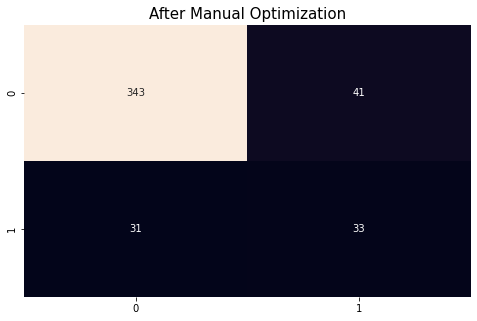

In [90]:
model = GaussianNB(var_smoothing = Gaussian_optimization())
model.fit(x_train, y_train)
final_y_pred = model.predict(x_test)

plt.figure(figsize=(8,5))
plt.title('After Manual Optimization', size=15 )
sns.heatmap(confusion_matrix(y_test, final_y_pred), annot = True, cbar = False, fmt = 'g');  # 51.56 % of (1) good predicts

### Tuning Hyperparameter with RandomizedSearchCV

In [70]:
# For GaussianDB
from sklearn.model_selection import RandomizedSearchCV

params_gauss = {'var_smoothing' : np.logspace(0,-9, num=100)}

search_gauss = RandomizedSearchCV(estimator=GaussianNB(), param_distributions=params_gauss, n_iter=100, cv = 9, scoring='f1')
search_gauss.fit(x_train, y_train)
search_gauss.best_params_

{'var_smoothing': 0.02848035868435802}

0.47058823529411764


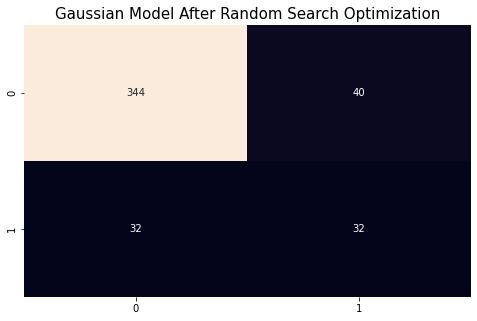

In [71]:
y_search_pred = search_gauss.predict(x_test)
print(f1_score(y_test, y_search_pred))

plt.figure(figsize=(8,5))
plt.title('Gaussian Model After Random Search Optimization', size=15)
sns.heatmap(confusion_matrix(y_test, y_search_pred), annot = True, cbar = False, fmt = 'g');

In [86]:
from sklearn.model_selection import GridSearchCV

params_gauss_grid = {'var_smoothing': np.linspace(0.01, 0.03, 50)}

grid = GridSearchCV(estimator=GaussianNB(), param_grid=params_gauss_grid, n_jobs=-1, cv = 5, scoring='f1')
grid.fit(x_train, y_train)
grid.best_params_

{'var_smoothing': 0.024285714285714285}

0.46715328467153283


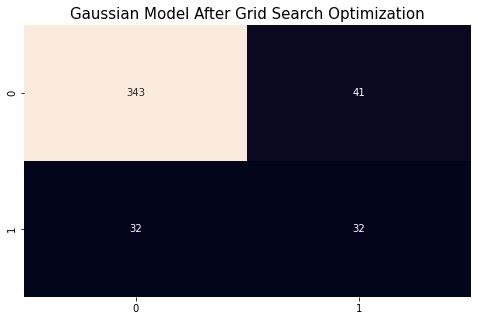

In [87]:
y_grid_pred = grid.predict(x_test)
print(f1_score(y_test, y_grid_pred))

plt.figure(figsize=(8,5))
plt.title('Gaussian Model After Grid Search Optimization', size=15)
sns.heatmap(confusion_matrix(y_test, y_grid_pred), annot = True, cbar = False, fmt = 'g');

# Feature Selection

In [91]:
x_train.shape

(1792, 29)

In [92]:
from sklearn.pipeline import make_pipeline

dict_f1_select = {}

def select_best_features():
    
    for i in range(1,30):
        model_select = make_pipeline(SelectKBest(f_classif, k = i), GaussianNB(var_smoothing=Gaussian_optimization()))
        model_select.fit(x_train, y_train)
        y_pred_feature = model_select.predict(x_test)
        dict_f1_select[f1_score(y_test, y_pred_feature)] = i 
        
    max_key = 0
    for element in dict_f1_select:
           if element > max_key :
                max_key = element
                
    return dict_f1_select.get(max_key)

In [93]:
select_best_features()

8

# Prediction 

In [94]:
final_model = make_pipeline(SelectKBest(f_classif, k = select_best_features()), 
                            GaussianNB(var_smoothing=Gaussian_optimization()))

final_model.fit(x_train, y_train)
final_predict = final_model.predict(x_test)

f1_score(y_test, final_predict)

0.5157232704402516

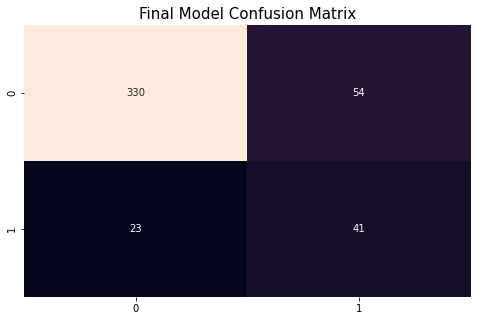

In [99]:
plt.figure(figsize=(8,5))
plt.title('Final Model Confusion Matrix', size=15)
sns.heatmap(confusion_matrix(y_test, final_predict), annot = True, cbar = False, fmt = 'g');

We can see that the minority class has evolved a lot! 64.0625% correct predictions.

In [109]:
y_test.shape

(448,)

In [108]:
final_predict.shape

(448,)

In [110]:
# Compare the prediction

final_tableau = pd.DataFrame()
final_tableau['Original'] = y_test
final_tableau['Prediction'] = final_predict

In [120]:
final_tableau.head()

,Original,Prediction
670,0,0
570,0,0
39,0,0
1909,0,0
2231,0,0


In [126]:
final_tableau.query('Original != Prediction and Prediction ==1').count()[0]

54

In [127]:
(54 / 77) * 100

70.12987012987013

In [118]:
final_tableau.query('Original != Prediction').count()

Original      77
Prediction    77
dtype: int64

In [119]:
(final_tableau.query('Original != Prediction').count()[0] / final_tableau.shape[0]) * 100

17.1875

For the predictions on our dataset, it has 17% error (bad predictions).